# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
import random
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction, preparing_to_predict, plot_metrics

In [3]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

### Data

In [4]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [5]:
train_merge = merge_basic(daily_train, test,'left')

In [6]:
train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,150983.0,2013-01-02
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,NaN,2013-01-03
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,NaN,2013-01-05
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,NaN,2013-01-06
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,NaN,2013-01-15


In [7]:
wholedata_silver = convert_silver(train_merge)

In [8]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,InTest,item_cnt_day,shopitem
0,2013-01-01,0,0,32,Кино - DVD,40,0,6.0,0-32
1,2013-01-01,0,0,33,Кино - Blu-Ray,37,0,3.0,0-33
2,2013-01-01,0,0,35,Кино - DVD,40,0,1.0,0-35
3,2013-01-01,0,0,43,Кино - DVD,40,0,1.0,0-43
4,2013-01-01,0,0,51,Музыка - MP3,57,0,2.0,0-51


In [9]:
wholedata_silver.shape

(1609124, 9)

<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [10]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [11]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

#### hold-out Train

In [12]:
date_val = datetime.datetime(2014, 10, 1)

In [13]:
train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ]\
    [['InTest','SaleDateMY','shop_id','item_id','item_category_id', 'item_category_name','item_cnt_day']].copy()

In [14]:
train_window.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,InTest,item_cnt_day,shopitem
0,2013-01-01,0,0,32,Кино - DVD,40,0,6.0,0-32
1,2013-01-01,0,0,33,Кино - Blu-Ray,37,0,3.0,0-33
2,2013-01-01,0,0,35,Кино - DVD,40,0,1.0,0-35
3,2013-01-01,0,0,43,Кино - DVD,40,0,1.0,0-43
4,2013-01-01,0,0,51,Музыка - MP3,57,0,2.0,0-51


In [15]:
train_window.SaleDateMY.max(), train_window.SaleDateMY.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [16]:
train_full = completion_semi_gold(train_window)

In [17]:
train_full.head()

,InTest,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,MiguelId
0,0,0,30,0-30,40,2013-01-01,0.0,1,0-30-2013-01-01
1,0,0,31,0-31,37,2013-01-01,0.0,1,0-31-2013-01-01
2,0,0,32,0-32,40,2013-01-01,6.0,1,0-32-2013-01-01
3,0,0,33,0-33,37,2013-01-01,3.0,1,0-33-2013-01-01
4,0,0,35,0-35,40,2013-01-01,1.0,1,0-35-2013-01-01


In [18]:
train_full.shape

(7034391, 9)

In [19]:
train_full.groupby('InTest').agg(shopitems = ('shopitem','nunique'))

,shopitems
InTest,
0,277766
1,57205


### Exploration of the features

In [20]:
def balance_items_test(data, percentage_test = 0.30, smalls_percent = 0.5, gen_sample = 0.70):
    
    data = data.copy()
    
    ## data from not in test
    
    items_in_test = list(data[data.InTest == 1].shopitem.unique())
    items_in_test = [str(x) for x in items_in_test]
    
    items_no_test = list(data[data.InTest == 0].shopitem.unique())
    items_no_test = [str(x) for x in items_no_test]
    ncapture = int(round(len(items_no_test)*percentage_test,0 ))
    random.shuffle(items_no_test)
    items_no_test = items_no_test[0:ncapture]
    
    selected_items = items_in_test + items_no_test
    data = data[data.shopitem.isin(selected_items)]
    
    ## data min item
    data['max'] = data.groupby(['shopitem']).Sale.transform('max')
    smalls = list(data[data['max'] < 2].shopitem.unique())
    to_drop = int( round(len(smalls)*smalls_percent,0 ))
    items = [str(x) for x in smalls]
    random.shuffle(items)
    keep_items = items[0:to_drop]
    data = data[~data.shopitem.astype('str').isin(keep_items)].drop(columns = ['max'])
    
    ## for general sample
    to_hide = int( round(len(data.shopitem.unique())*gen_sample,0 ))
    items = list(data.shopitem.unique())
    items = [str(x) for x in items]
    random.shuffle(items)
    
    keep_items = items[0:to_hide]
    data_result = data[data.shopitem.astype('str').isin(keep_items)]
    
    return data_result

<b> scalling shopitem wise over L 1 differenciation per shopitem

In [23]:
def get_starts_items(data_whole, data_train):
    df_orders = data_train.groupby(['Date','Order']).count().reset_index()
    max_date = df_orders.Date.max()
    max_order = df_orders.Order.max()
    
    min_wholedate = data_whole.SaleDateMY.min()
    max_wholedate = data_whole.SaleDateMY.max()

    listdate_1 = [max_date]
    listorder_1 =  [max_order]

    datex = listdate_1[0]
    ordernew = listorder_1[0]
    while datex > min_wholedate:
        datex = datex - relativedelta(months = 1)
        ordernew = ordernew - 1
        listdate_1.append(datex), listorder_1.append(ordernew)

    map_order = pd.DataFrame({'Date':listdate_1,'Order':listorder_1})
    
    data = data_whole[data_whole.SaleDateMY <= max_date ].copy()
    data = data.rename(columns = {'SaleDateMY':'Date','item_cnt_day':'Sale'})
    data = data.merge(map_order, on = 'Date',how = 'left')
    
    starts = data.pivot_table(index= ['item_id','item_category_id','Order'] ,values = ['Sale'], aggfunc = 'max').reset_index()
    
    starts['possnumb'] = np.where(starts.Sale > 0 , 1,0)
    starts['maxOrder'] = starts.groupby(['item_id','possnumb']).cumcount() + 1
    starts['maxOrder'] = np.where(starts.possnumb == 0 , 0, starts['maxOrder'] )
    starts['OrderGot'] = np.where(starts.maxOrder == 1, starts.Order,0)
    starts['OrderGot'] = starts.groupby(['item_id']).OrderGot.transform('sum')
              
    starts = starts.groupby('item_id').agg(OrderGot = ('OrderGot','max')).reset_index()
    
    return starts

In [91]:
def feature_silver(data, starters, date_to_take, Train = True):
    
    if Train:
        data_long = data.copy()
        data = data.copy()
        data = data[ data.Date < date_to_take] 
    else:
        data = data.copy()
        data = data[data.Date >= (date_to_take - relativedelta(months = 15))]
    
    ## feature of diff using one lag
    data['SaleL1M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
    data['SaleL2M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(2)
    
    data_lagdiff = data.assign(L0M_L1M = data.Sale - data.SaleL1M)  ### This is new target ???? but yeaaaaaHHH
    data_lagdiff = data_lagdiff.assign(L1M_L2M = data_lagdiff.SaleL1M - data_lagdiff.SaleL2M) 
    
    data_lagdiff = data_lagdiff.drop(columns = ['SaleL2M'])
    ## quasi ids
    data_lagdiff['ItemIdPart1'] = data_lagdiff.item_id.astype('str').str.strip().str[-1]
    data_lagdiff['ItemIdPart2'] = data_lagdiff.item_id.astype('str').str.strip().str[0]
    data_lagdiff['ItemIdPart3'] = data_lagdiff.item_id.astype('str').str.strip().str[0:2]
    data_lagdiff['shopIdPart1'] = data_lagdiff.shop_id.astype('str').str.strip().str[-1]
    data_lagdiff['shopIdPart2'] = data_lagdiff.shop_id.astype('str').str.strip().str[0]
    
    ## further quasi id
    data_lagdiff['CategIdItem3'] =  data_lagdiff['ItemIdPart3'].astype('int') % 4
    data_lagdiff['CategIdItem2'] =  data_lagdiff['ItemIdPart2'].astype('int') % 4
    
    ## month
    data_lagdiff = data_lagdiff.assign(month = data_lagdiff.Date.dt.month)
    
    max_date = data_lagdiff.Date.max() + relativedelta(months=1)
    max_date_month = max_date.month
    data_lagdiff['monthToPredict'] = np.where(data_lagdiff['month'] == max_date_month,1,0)
        
    ## year
    data_lagdiff['Year'] = data_lagdiff.Date.dt.year
    ## quarter
    data_lagdiff['Quarter'] = np.where(data_lagdiff.month.isin([1,2,3]),1,
                            np.where(data_lagdiff.month.isin([4,5,6]),2,
                            np.where(data_lagdiff.month.isin([7,8,9]),3,
                            np.where(data_lagdiff.month.isin([10,11,12]),4,0))))
    
    if Train:

        #########################################
        ### only item Columns  ##################
        ########################################

        def q1(x):
            return x.quantile(0.25)

        def q2(x):
            return x.quantile(0.50)

        def q3(x):
            return x.quantile(0.90)

        date_max = data_lagdiff.Date.max()
        date_max = datetime.datetime(date_max.year, date_max.month, date_max.day)
        begin_date = date_max - relativedelta(months = 14)

        df_feature = data_lagdiff[data_lagdiff.Date >= begin_date]\
            .groupby(['item_id','Date'])\
            .agg( lowValueItem = ('Sale', q1), 
                medianValueItem = ('Sale',q2),
                highValueItem = ('Sale',q3),
                maxValueItem = ('Sale','max'))\
            .reset_index()
        df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
        df_feature['RangeValueItem'] = df_feature.maxValueItem - df_feature.medianValueItem
        
        ## lags 
        df_feature['L1medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(1)
        df_feature['L2medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(2)
        df_feature['L3medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(3)
        df_feature['L11medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(11)
        df_feature['L12medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(12)

        df_feature = df_feature.assign(L1M_L2MItem = df_feature.medianValueItem - df_feature.L1medianValueItem)
        df_feature = df_feature.assign(L1M_L3MItem = df_feature.medianValueItem - df_feature.L2medianValueItem)
        df_feature = df_feature.assign(L1M_L4MItem = df_feature.medianValueItem - df_feature.L3medianValueItem)
        df_feature = df_feature.assign(L1M_L12MItem = df_feature.medianValueItem - df_feature.L11medianValueItem)
        df_feature = df_feature.assign(L1M_L13MItem = df_feature.medianValueItem - df_feature.L12medianValueItem)
        
        ## lags 
        df_feature['L1maxValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItem'].shift(1)
        df_feature['L2maxValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItem'].shift(2)
        df_feature['L3maxValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItem'].shift(3)
        df_feature['L11maxValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItem'].shift(11)
        df_feature['L12maxValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItem'].shift(12)
        
        df_feature = df_feature.assign(L1M_L2MItemMax = df_feature.maxValueItem - df_feature.L1maxValueItem)
        df_feature = df_feature.assign(L1M_L3MItemMax = df_feature.maxValueItem - df_feature.L2maxValueItem)
        df_feature = df_feature.assign(L1M_L4MItemMax = df_feature.maxValueItem - df_feature.L3maxValueItem)
        df_feature = df_feature.assign(L1M_L12MItemMax = df_feature.maxValueItem - df_feature.L11maxValueItem)
        df_feature = df_feature.assign(L1M_L13MItemMax = df_feature.maxValueItem - df_feature.L12maxValueItem)

        df_feature = df_feature.drop(columns = ['L1medianValueItem', 'L2medianValueItem', 'L3medianValueItem', 'L11medianValueItem', 'L12medianValueItem',
                                               'L1maxValueItem', 'L2maxValueItem', 'L3maxValueItem', 'L11maxValueItem', 'L12maxValueItem',
                                               'lowValueItem', 'medianValueItem', 'highValueItem', 'maxValueItem'])

        ## count recent 0
        df_feature['count0'] = np.where(df_feature.L1M_L2MItem == 0,1,0)
        df_feature['Roll0L1Item'] = df_feature.sort_values('Date').groupby(['item_id']).count0.transform(lambda x: x.rolling(4, 1).sum())
        df_feature_item = df_feature.drop(columns = ['count0'])
        
        df_feature['count0'] = np.where(df_feature.L1M_L2MItemMax == 0,1,0)
        df_feature['Roll0L1ItemMax'] = df_feature.sort_values('Date').groupby(['item_id']).count0.transform(lambda x: x.rolling(4, 1).sum())
        df_feature_item = df_feature.drop(columns = ['count0'])

        features_dictionary = {'Focus_item_features': df_feature_item}

        ########################################
        ############ END  ##############
        ########################################
        
        
        ###############################################
        ####### maps for feature highVariation #######
        ###############################################

        df_feature = data_lagdiff[['shop_id','item_id','shopitem','item_category_id','Date', 'Sale']].copy()
        df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
        df_feature['count0'] = np.where(df_feature.Sale == 0,1,0)
        df_feature['month'] = df_feature['Date'].dt.month
        df_feature['count0'] = df_feature.sort_values('Date').groupby(['shopitem']).count0.transform('sum')
        df_feature['SaleNew'] = np.where(df_feature.Sale == 0,np.nan, df_feature.Sale)
        df_feature['minSale'] = df_feature.sort_values('Date').groupby(['shopitem']).SaleNew.transform('min')
        df_feature['SaleL1M'] = df_feature.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
        df_feature = df_feature.assign(L0M_L1M = df_feature.Sale - df_feature.SaleL1M)
        df_feature['maxVar'] = df_feature.groupby(['shopitem']).L0M_L1M.transform('max')

        df_feature = df_feature[(abs(df_feature.maxVar) > 3) &(df_feature.count0 < 6)]

        df_feature['Year'] = df_feature.Date.dt.year
        df_feature['Quarter'] = np.where(df_feature.month.isin([1,2,3]),1,
                                np.where(df_feature.month.isin([4,5,6]),2,
                                np.where(df_feature.month.isin([7,8,9]),3,
                                np.where(df_feature.month.isin([10,11,12]),4,0))))

        feature_med = df_feature.groupby(['item_id','Year','Quarter','month']).agg(medianVar = ('L0M_L1M',q2),
                                                                     highVar = ('L0M_L1M',q3)).reset_index()
        feature_med['HighMeanQuart'] = feature_med.groupby(['Year','Quarter']).highVar.transform('mean')
        feature_med['medianVarL12'] = feature_med.sort_values(['Year','month']).groupby(['item_id'])['medianVar'].shift(12)
        feature_med['HighVarL12'] = feature_med.sort_values(['Year','month']).groupby(['item_id'])['highVar'].shift(12)

        feature_var_season = feature_med.groupby(['item_id','Year','Quarter'])[['HighMeanQuart']].max().reset_index()
        feature_var_season['HighMeanQuartL4'] = feature_var_season.sort_values(['Year','Quarter']).groupby(['item_id'])['HighMeanQuart'].shift(4)
        feature_var_season = feature_var_season.fillna(0)
        feature_var_season['SeasonalVariation'] = feature_var_season.HighMeanQuart - feature_var_season.HighMeanQuartL4
        feature_var_season = feature_var_season.drop(columns = 'HighMeanQuart')


        feature_med = feature_med.merge(feature_var_season, on = ['item_id','Year','Quarter'],how = 'left')
        feature_med = feature_med[['item_id','Year','month','medianVarL12','SeasonalVariation','HighVarL12']]

        features_dictionary['HighVarSeason'] = feature_med
        ####################################
        ##### end ##########################
        ####################################
        
        #####################################
        ### shop sale average on items
        ####################################
        df_feature = data_lagdiff[['shop_id','item_id','shopitem','item_category_id','Date', 'Sale']].copy()
        df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
        df_feature = data_lagdiff.assign( possCounts = np.where(df_feature.Sale > 0, 1, 0) )
        df_feature['possCounts'] = df_feature.groupby(['shopitem']).possCounts.transform(lambda x: x.sum())
        df_feature['SaleL1M'] = df_feature.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
        df_feature = df_feature.assign(L0M_L1M = df_feature.Sale - df_feature.SaleL1M)
        df_feature['maxVar'] = df_feature.groupby(['shopitem']).L0M_L1M.transform('max')
        
        df_feature = df_feature[df_feature.maxVar < 4].copy()

        df_feature_shop = df_feature.groupby(['shop_id','month']).agg(sumVarShop = ('L0M_L1M','sum')).reset_index()
        df_feature_item = df_feature[df_feature.possCounts < 5].groupby(['item_id','month']).agg(maxSmallItemVar = ('L0M_L1M','max'))

        features_dictionary['SmallItemVars'] = df_feature_item
        features_dictionary['ShopVarMax'] = df_feature_shop

        ####################################
        ##### end ##########################
        ####################################

        #########################################
        ### only shops Columns  ##################
        ########################################

        df_feature = data_lagdiff[data_lagdiff.Date >= begin_date]\
            .groupby(['shop_id','Date'])\
            .agg( lowValueShop = ('Sale', q1), 
                medianValueShop = ('Sale',q2),
                highValueShop = ('Sale',q3),
                maxValueShop = ('Sale','max'))\
            .reset_index()
        df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
        df_feature['RangeValueShop'] =  df_feature.maxValueShop - df_feature.medianValueShop
        features_dictionary['Focus_shop_features'] = df_feature
        
        ## lags 
        df_feature['L1medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['maxValueShop'].shift(1)
        df_feature['L2medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['maxValueShop'].shift(2)
        df_feature['L3medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['maxValueShop'].shift(3)
        df_feature['L11medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['maxValueShop'].shift(11)
        df_feature['L12medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['maxValueShop'].shift(12)

        df_feature = df_feature.assign(L1M_L2MShop = df_feature.medianValueShop - df_feature.L1medianValueShop)
        df_feature = df_feature.assign(L1M_L3MShop = df_feature.medianValueShop - df_feature.L2medianValueShop)
        df_feature = df_feature.assign(L1M_L4MShop = df_feature.medianValueShop - df_feature.L3medianValueShop)
        df_feature = df_feature.assign(L1M_L12MShop = df_feature.medianValueShop - df_feature.L11medianValueShop)
        df_feature = df_feature.assign(L1M_L13MShop = df_feature.medianValueShop - df_feature.L12medianValueShop)

        df_feature = df_feature.drop(columns = ['L1medianValueShop', 'L2medianValueShop', 'L3medianValueShop', 'L11medianValueShop', 'L12medianValueShop',
                                               'lowValueShop', 'medianValueShop', 'highValueShop', 'maxValueShop'])

        ## count recent 0
        df_feature['count0'] = np.where(df_feature.L1M_L2MShop == 0,1,0)
        df_feature['Roll0L1shop'] = df_feature.sort_values('Date').groupby(['shop_id']).count0.transform(lambda x: x.rolling(4, 1).sum())
        df_feature_shop = df_feature.drop(columns = ['count0'])

        features_dictionary['Focus_shop_features'] = df_feature_shop        

        ####################################
        ##### end ##########################
        ####################################
        
        #######################################
        ### for feature explosion 
        #######################################
        
        df_feature = data_lagdiff.merge(starters, on = 'item_id', how = 'left')

        ### the reorder gives the date x gap to OrderGot
        df_feature['reorder'] = df_feature['Order'] - df_feature['OrderGot'] 

        ### the lag diff gives the estimated variation
        df_feature['SaleL1M'] = df_feature.sort_values('Order').groupby(['item_id'])['Sale'].shift(1)
        df_feature = df_feature.assign(L1M_L2M = df_feature.Sale - df_feature.SaleL1M) 

        
        ## feature  percentile variation for 3 times after start
        df_feature_explosions = df_feature[(df_feature.reorder >= 0) & (df_feature.reorder <= 5)]\
            .groupby(['OrderGot', 'reorder']).agg(EstimVar = ('L1M_L2M','mean'))\
            .reset_index().sort_values(['OrderGot','reorder'],ascending = False)\
            .groupby('reorder').agg(EstimVar = ('EstimVar','mean'))
        
        features_dictionary['items_explosions'] = df_feature_explosions

    
        ####################################
        ##### end ##########################
        ####################################
        
        
        data_result = data_lagdiff
        return data_result, features_dictionary
        
    else:
        data_result = data_lagdiff
        
        return data_result

In [92]:
def integration_new_features_map(data, dict_feature, Starters, val_date = None):
    data_wow = data.copy()
        
    ## first merge
    data_wow = data_wow.merge(dict_feature['Focus_item_features'], on = ['item_id','Date'], how = 'left')
    data_wow = data_wow.merge(dict_feature['Focus_shop_features'], on = ['shop_id','Date'], how = 'left')
    data_wow = data_wow.merge(dict_feature['HighVarSeason'], on = ['item_id','Year','month'], how = 'left')
    data_wow = data_wow.merge(dict_feature['ShopVarMax'], on = ['shop_id','month'], how = 'left')
    data_wow = data_wow.merge(dict_feature['SmallItemVars'], on = ['item_id','month'], how = 'left')
    
    ## especial merge and additional features
    data_wow = data_wow.merge(Starters, on = ['item_id'], how = 'left')
    data_wow['reorder'] = data_wow['Order'] - data_wow['OrderGot']
    data_wow['reorder'] = np.where(data_wow['reorder'].isna(), 0, data_wow['reorder'])
    data_wow['NewItemIdAppeared'] = np.where(data_wow.Order > data_wow.OrderGot,1,0) 
    data_wow = data_wow.merge(dict_feature['items_explosions'], on = ['reorder'], how = 'left')

    return data_wow

In [93]:
starts = get_starts_items(wholedata_silver, train_full)

In [94]:
data_train_selected = balance_items_test(train_full, percentage_test = 0.30, smalls_percent = 0.5, gen_sample = 0.05)

In [95]:
data_train_selected.shape

(106386, 9)

In [96]:
%%time
train_feature_tocomplete, features_dictionary = feature_silver(data_train_selected, starts, date_to_take = date_val)

Wall time: 2min


In [97]:
train_feature = integration_new_features_map(data = train_feature_tocomplete, dict_feature = features_dictionary, Starters = starts) 

In [98]:
def features_rows_train_silver(data, features, target ,validation = None, dates_back = 3):
    data = data.copy()
    if validation:
        data_result = data[ data.Date == validation][features + [target]]
        features_new = list(data_result.columns)
        features_new.remove(target)
        data_result = data_result[features_new + [target]].fillna(0)
        
    else:
        ### splits
        ### conventional for regular time series
    
        cutoff = 3
        
        ### Date cqpture ####################
        date_max = data.Date.max()
        months_to_get = [4,5,6,10,11]
        minyear = 2014
        min_date = date_max - relativedelta(months=dates_back)

        year_i = date_max.year

        dates_result = list()

        while year_i >= minyear:
            for monthi in months_to_get:
                dates_result.append(datetime.datetime(year_i, monthi, 1))
                dates_result = [x for x in dates_result if x <= date_max]
            year_i = year_i - 1

        dates_result = dates_result + [date_max - relativedelta(months=i) for i in range(0,dates_back +1)]
        dates_result = list(set(dates_result))
        dates_result.sort()
        ######################################
    
        data_result = data[data.Date.isin(dates_result)][features + [target]].fillna(0)

    return data_result

In [99]:
train_feature.columns

Index(['InTest', 'shop_id', 'item_id', 'shopitem', 'item_category_id', 'Date',
       'Sale', 'Order', 'MiguelId', 'SaleL1M', 'L0M_L1M', 'L1M_L2M',
       'ItemIdPart1', 'ItemIdPart2', 'ItemIdPart3', 'shopIdPart1',
       'shopIdPart2', 'CategIdItem3', 'CategIdItem2', 'month',
       'monthToPredict', 'Year', 'Quarter', 'RangeValueItem', 'L1M_L2MItem',
       'L1M_L3MItem', 'L1M_L4MItem', 'L1M_L12MItem', 'L1M_L13MItem',
       'L1M_L2MItemMax', 'L1M_L3MItemMax', 'L1M_L4MItemMax', 'L1M_L12MItemMax',
       'L1M_L13MItemMax', 'Roll0L1Item', 'Roll0L1ItemMax', 'RangeValueShop',
       'L1M_L2MShop', 'L1M_L3MShop', 'L1M_L4MShop', 'L1M_L12MShop',
       'L1M_L13MShop', 'Roll0L1shop', 'medianVarL12', 'SeasonalVariation',
       'HighVarL12', 'sumVarShop', 'maxSmallItemVar', 'OrderGot', 'reorder',
       'NewItemIdAppeared', 'EstimVar'],
      dtype='object')

In [100]:
to_drop_columns = ['Date','Sale','SaleL1M']
ids_columns = ['shop_id','item_category_id','ItemIdPart1', 'ItemIdPart2', 'ItemIdPart3', 'shopIdPart1',
       'shopIdPart2', 'CategIdItem3', 'CategIdItem2'] #'item_id'
numericals = ['month',
       'monthToPredict', 'Year', 'Quarter', 'RangeValueItem', 'L1M_L2MItem',
       'L1M_L3MItem', 'L1M_L4MItem', 'L1M_L12MItem', 'L1M_L13MItem',
       'L1M_L2MItemMax', 'L1M_L3MItemMax', 'L1M_L4MItemMax', 'L1M_L12MItemMax',
       'L1M_L13MItemMax', 'Roll0L1Item', 'Roll0L1ItemMax', 'RangeValueShop',
       'L1M_L2MShop', 'L1M_L3MShop', 'L1M_L4MShop', 'L1M_L12MShop',
       'L1M_L13MShop', 'Roll0L1shop', 'medianVarL12', 'SeasonalVariation',
       'HighVarL12', 'sumVarShop', 'maxSmallItemVar', 'OrderGot', 'reorder',
       'NewItemIdAppeared', 'EstimVar'] + ids_columns
categoricals = []
my_features = to_drop_columns + numericals + categoricals
my_target = 'L0M_L1M'
len(my_features) - 3

42

In [101]:
train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target)

### continue ...

In [102]:
def scaler(dataset, features, target, scaler=None, drop_columns = []):
    if scaler:
        features = [x for x in features if x not in drop_columns]
        df = dataset[features + [target]]
        df_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(df_scaled, columns = df.columns, index = df.index)
        return dataset_scaled
    
    else:
        features = [x for x in features if x not in drop_columns]
        df  = dataset[features + [target]]
        scaler = MinMaxScaler()
        scaler.fit(df)

        dataset_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(dataset_scaled, columns = df.columns, index = df.index)
        return dataset_scaled, scaler

In [103]:
my_columns_to_drops = ['Year', 'monthToPredict', 'Roll0L1shop', 'SeasonalVariation','L1M_L13MItemMax', 'Quarter']
train_scaled, my_scaler = scaler(train_selection, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
if len(categoricals) != 0:
    train_dummies = pd.get_dummies(train_selection[categoricals])
    train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [104]:
if len(categoricals) != 0:
    final_features = list(train_dummies.columns) +  numericals
else:
    final_features = numericals
final_features = [x for x in final_features if x not in my_columns_to_drops]

In [105]:
train_scaled.head()

,month,RangeValueItem,L1M_L2MItem,L1M_L3MItem,L1M_L4MItem,L1M_L12MItem,L1M_L13MItem,L1M_L2MItemMax,L1M_L3MItemMax,L1M_L4MItemMax,...,shop_id,item_category_id,ItemIdPart1,ItemIdPart2,ItemIdPart3,shopIdPart1,shopIdPart2,CategIdItem3,CategIdItem2,L0M_L1M
75990,0.0,0.000000,0.428571,0.483871,0.603306,0.802817,0.652893,0.431111,0.455319,0.561644,...,0.0,0.679012,1.000000,0.500,0.550562,0.0,0.0,1.000000,0.333333,0.561111
75991,0.0,0.000000,0.428571,0.483871,0.603306,0.802817,0.652893,0.431111,0.455319,0.561644,...,0.0,0.925926,0.777778,0.625,0.617978,0.0,0.0,0.333333,0.666667,0.561111
75992,0.0,0.004762,0.434524,0.489247,0.607438,0.802817,0.652893,0.435556,0.459574,0.565068,...,0.0,0.802469,0.777778,0.000,0.000000,0.0,0.0,0.666667,0.333333,0.561111
75993,0.0,0.000000,0.428571,0.483871,0.603306,0.802817,0.652893,0.431111,0.455319,0.561644,...,0.0,0.925926,0.777778,0.000,0.000000,0.0,0.0,0.666667,0.333333,0.561111
75994,0.0,0.000000,0.428571,0.483871,0.603306,0.802817,0.652893,0.431111,0.455319,0.561644,...,0.0,0.333333,0.222222,0.000,0.044944,0.0,0.0,0.666667,0.333333,0.561111


In [106]:
train_scaled.shape, train_selection.shape

((30396, 37), (30396, 46))

### ML modeling using ADAboost

In [107]:
X_train = train_scaled[final_features]
Y_train = train_scaled[my_target]

In [108]:
%%time
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 30, min_samples_split = 10, min_samples_leaf = 10 , max_features = 25)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=40, learning_rate=0.005, loss='linear')
my_ABM.fit(X_train, Y_train)

Wall time: 17.5 s


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=30,
                                                       max_features=25,
                                                       min_samples_leaf=10,
                                                       min_samples_split=10),
                  learning_rate=0.005, n_estimators=40)

<b> hold out validation

In [109]:
full_valandtrain = preparing_to_predict(val_data = val_window, train_data = train_window)
full_valandtrain_selected = completion_semi_gold(full_valandtrain)

In [110]:
valandtrain_feature = feature_silver(full_valandtrain_selected, starts, date_to_take = date_val, Train = False)
valandtrain_feature = integration_new_features_map(data = valandtrain_feature, dict_feature= features_dictionary, val_date = date_val, Starters = starts) 

In [111]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, validation = date_val) 

In [112]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )

if len(categoricals) != 0:
    val_dummies = pd.get_dummies(val_selection[categoricals])
    val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
else:
    val_scaled_full = val_scaled

In [113]:
X_val = val_scaled_full[final_features]

In [114]:
Y_pred = my_ABM.predict(X_val)

In [115]:
predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)

In [116]:
my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.L0M_L1M.values)

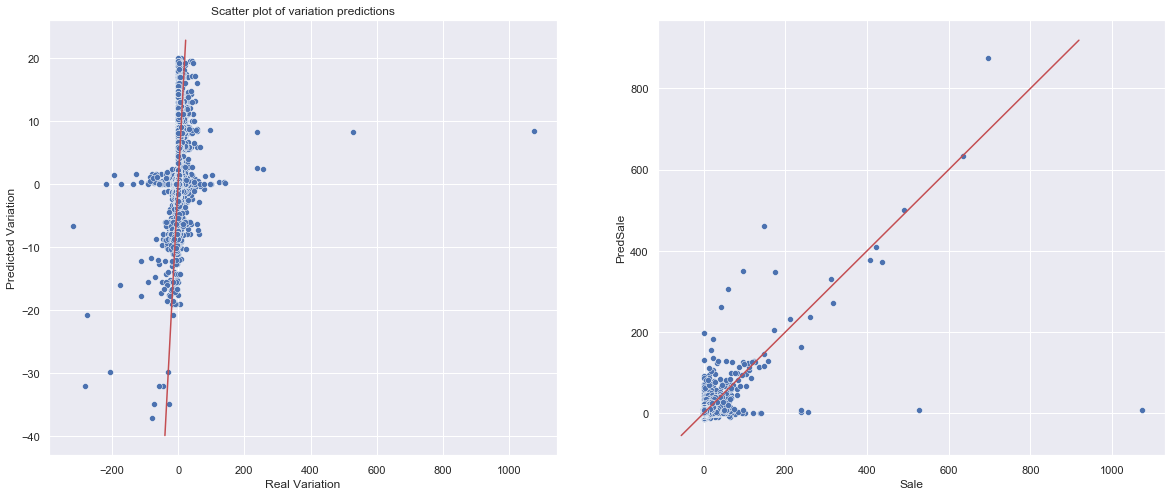

In [117]:
plot_prediction(my_lm_plot)

[Text(0.5, 1.0, 'feature importance')]

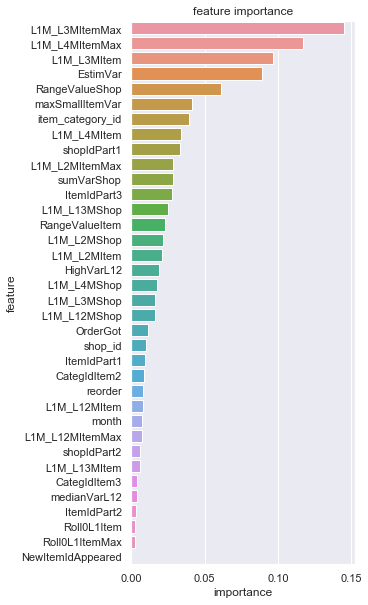

In [118]:
dfplot = pd.DataFrame({'feature':final_features,'importance': list(my_ABM.feature_importances_)}).sort_values('importance',ascending = False)

fig = plt.figure(figsize=(4,10))
ax = sns.barplot(x="importance", y="feature", data=dfplot)
ax.set(title='feature importance')

In [119]:
dfplot.sort_values('importance').head(6).feature.values

array(['NewItemIdAppeared', 'Roll0L1ItemMax', 'Roll0L1Item',
       'ItemIdPart2', 'medianVarL12', 'CategIdItem3'], dtype=object)

### Production of folds for cross validation

In [49]:
sample_degree = 0.005
for date_val in test_dates:
    date_val_str = date_val.strftime('%Y-%m-%d')
    train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
    val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ]\
        [['InTest','SaleDateMY','shop_id','item_id','item_category_id', 'item_category_name','item_cnt_day']].copy()
    train_full = completion_semi_gold(train_window)
    data_train_selected = balance_items_test(train_full, percentage_test = 0.30, smalls_percent = 0.5, gen_sample = sample_degree)
    train_feature, features_dictionary = feature_silver(data_train_selected, date_to_take = date_val)
    train_feature = integration_new_features_map(data = train_feature, dict_feature= features_dictionary) 
    train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target)
    
    full_valandtrain = preparing_to_predict(val_data = val_window, train_data = train_window)
    full_valandtrain_selected = completion_semi_gold(full_valandtrain)
    valandtrain_feature = feature_silver(full_valandtrain_selected, date_to_take = date_val, Train = False)
    valandtrain_feature = integration_new_features_map(data = valandtrain_feature, dict_feature= features_dictionary, val_date = date_val) 
    val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, validation = date_val)  
    
    ### Saving DataFrames
    outdir = f'./generated_datasets/data_{date_val_str}/'
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    train_name = os.path.join(outdir, 'train_selection.csv') 
    train_selection.to_csv(path_or_buf = train_name,header=True, index=False)
    
    val_name = os.path.join(outdir, 'val_selection.csv') 
    val_selection.to_csv(path_or_buf = val_name,header=True, index=False)
    
    print(f'the datasets for the date {date_val_str}')

the datasets for the date 2014-11-01
the datasets for the date 2015-04-01
the datasets for the date 2015-05-01
the datasets for the date 2015-06-01
the datasets for the date 2015-07-01
the datasets for the date 2015-08-01
the datasets for the date 2015-09-01
the datasets for the date 2015-10-01


In [50]:
def My_ML_prediction_on_test(dates_vector, model, frac = 0.80):

    data_result = list()

    for datex in dates_vector:
        datex_str = datex.strftime('%Y-%m-%d')
        #### reading files
        train_selection = pd.read_csv(f'generated_datasets/data_{datex_str}/train_selection.csv')
        val_selection = pd.read_csv(f'generated_datasets/data_{datex_str}/val_selection.csv')
        
        train_scaled, my_scaler = scaler(train_selection, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
        if len(categoricals) != 0:
            train_dummies = pd.get_dummies(train_selection[categoricals])
            train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)
        
        ### ML train
        X_train = train_scaled[final_features]
        Y_train = train_scaled[my_target]
        model.fit(X_train, Y_train)
        
        ### Test data prepa
        val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )
        
        if len(categoricals) != 0:
            val_dummies = pd.get_dummies(val_selection[categoricals])
            val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
        else:
            val_scaled_full = val_scaled
        
        X_val = val_scaled_full[final_features]
        
        ## Prediction
        Y_pred = model.predict(X_val)
        
        ## Saving Result
        predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
        my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.L0M_L1M.values)
        data_result.append(my_lm_plot)
        #print(f'the prediction over the {datex} data is done')
        
    return pd.concat(data_result)

In [51]:
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 30, min_samples_split = 10, min_samples_leaf = 10 , max_features = 25)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=40, learning_rate=0.005, loss='linear')
my_test_results = My_ML_prediction_on_test( dates_vector = test_dates, model = my_ABM, frac = 0.50)

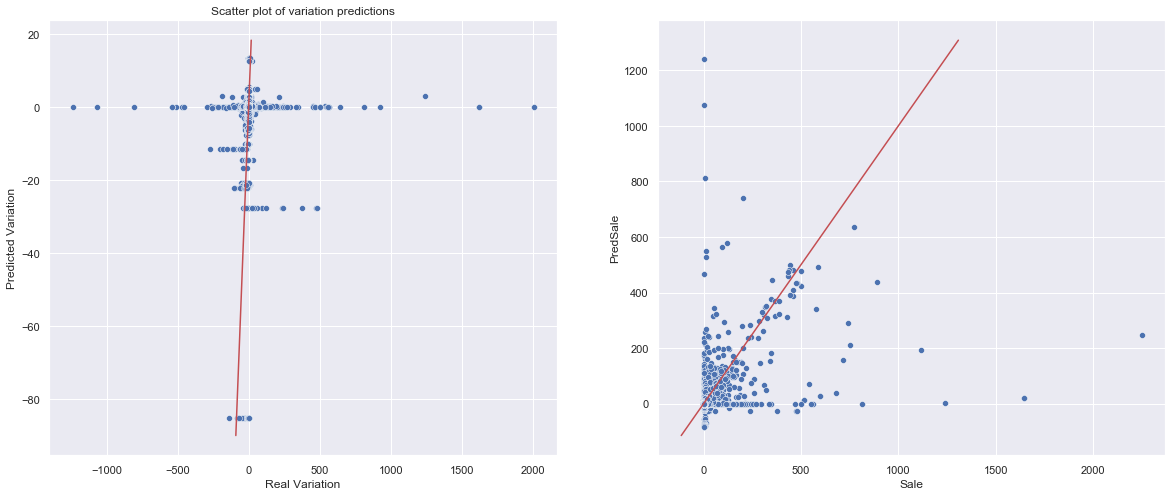

In [52]:
plot_prediction(my_test_results)

In [53]:
rmse_results = plot_metrics(my_test_results)

In [54]:
rmse_results.RMSE.mean()

9.675372773060358

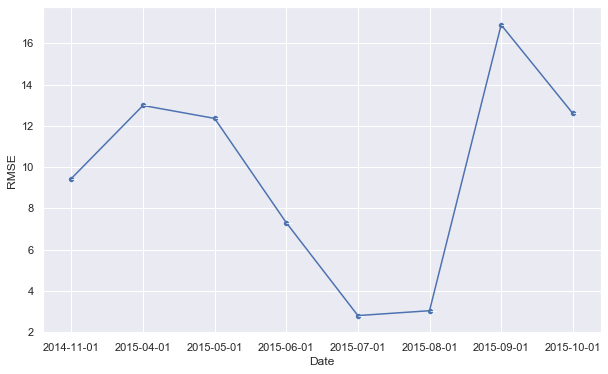

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10,6), sharex=True)
ax = sns.lineplot(ax = axs , data = rmse_results, x="Date", y="RMSE", marker = True, )
ax = sns.scatterplot(ax = axs , data = rmse_results, x="Date", y="RMSE", s = 35 )

<b> checking errors

In [56]:
my_test_results_melt = my_test_results.assign(Class = np.where( my_test_results.Sale > 10, 'A',
                                                      np.where( my_test_results.Sale > 7, 'B',
                                                      np.where( my_test_results.Sale > 5, 'C',
                                                      np.where( my_test_results.Sale > 3, 'D','E')))))\
                            .assign(ABSerror = abs(my_test_results.Sale - my_test_results.PredSale))

In [57]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 75) )

ABSerror                                      
Class               A         B         C       D         E
Date                                                       
2014-11-01  26.500000  8.846154  6.000000  3.9375  1.100000
2015-04-01  27.000000  9.000000  6.000000  4.0000  1.000000
2015-05-01  32.000000  8.986842  6.000000  4.0000  1.000000
2015-06-01  26.000000  8.000000  6.000000  4.0000  1.000000
2015-07-01  15.000000  8.000000  6.000000  4.0000  1.000000
2015-08-01  15.333333  7.912879  5.914773  4.0000  1.000000
2015-09-01  24.875000  9.000000  6.000000  4.0000  1.000000
2015-10-01  22.653846  8.996503  6.000000  4.0000  1.005102

In [58]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 100) )

ABSerror                                                 
Class                 A           B           C           D            E
Date                                                                    
2014-11-01   640.000000   53.062500   69.111111   39.250000  1071.111111
2015-04-01  1238.800000  151.000000  128.157895   87.100000    85.100000
2015-05-01   550.000000   45.000000  252.000000  808.000000  1240.000000
2015-06-01   540.000000   90.000000   55.578947   75.000000    84.000000
2015-07-01    97.000000   30.000000   22.888889   28.277778   108.000000
2015-08-01   144.000000   44.000000   18.000000   43.181818    55.000000
2015-09-01  1625.000000   33.000000   19.000000   41.000000    25.000000
2015-10-01  2006.833333   54.307692   66.000000   61.210526    51.006993

some improvement :/
improve algo speed

### Basic K flod with Parameter tunning

In [72]:
my_adab_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [25,30, 40, 55, 30, 25, 19, 34, 50, 35],
    'min_samples_split':[5, 4, 10, 7, 9, 15, 3, 3, 5, 5],
    'min_samples_leaf':[10, 7, 12, 5, 4, 3, 3, 3, 15, 12],
    'max_features':[25, 30, 25, 25, 30, 27, 30, 22, 25, 26],
              
    'n_estimators' : [50, 45, 90, 100, 50, 35, 150, 120, 85, 60],
    'learning_rate' : [0.05, 0.12, 0.02, 0.04, 0.004, 0.0003, 0.15, 0.08, 0.001, 0.005] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = max_depth_param, min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param , max_features = max_features_param)
    my_adab = AdaBoostRegressor(base_estimator = my_base, n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='linear')
    my_adab_models.append(my_adab)

parameters_df = pd.DataFrame(parameters)  

In [111]:
def my_kfold_crossval_and_Hptunning(models_toTrain,frac = 1.0):

    results = {'machine label': list(),
        'machine result': list()}

    for machine,i in zip(models_toTrain, range(1,len(models_toTrain) + 1)):
        label = f'machine-{i}'
        results['machine label'].append(label)
        df_result = My_ML_prediction_on_test( dates_vector = test_dates, model = machine, frac = frac)
        results['machine result'].append(df_result)
        print(label + ' is done')
        
    return results

In [74]:
my_test_results = my_kfold_crossval_and_Hptunning(models_toTrain =  my_adab_models, frac = 0.5)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done


In [81]:
def consolidated_plot_metrics(data):
    list_dfplot = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        df_plot = plot_metrics(result_detail)
        df_plot['machine'] = label
        list_dfplot.append(df_plot)
    
    return pd.concat(list_dfplot)

In [82]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

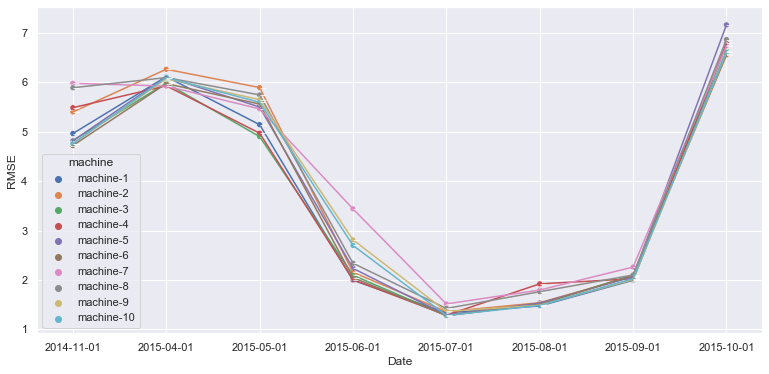

In [85]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [103]:
def consolidated_metrics_MSE(data):
    labels = list()
    RMSEs = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        pred = result_detail['Sale']
        real = result_detail['PredSale']
        rmse = mean_squared_error(real,pred)**(1/2)
        labels.append(label)
        RMSEs.append(rmse)
    
    return pd.DataFrame({'machine':labels,'RMSE': RMSEs}).sort_values('RMSE')

In [104]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
2,machine-3,4.152451
5,machine-6,4.218822
0,machine-1,4.240039
3,machine-4,4.273596
9,machine-10,4.297549
8,machine-9,4.313410
4,machine-5,4.393479
1,machine-2,4.396437
7,machine-8,4.498563
6,machine-7,4.517151


The winer is machine 3

### Winner Prediction

In [115]:
my_test_results = my_kfold_crossval_and_Hptunning(models_toTrain =  [my_adab_models[2]], frac = 1.0)

machine-1 is done


In [116]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

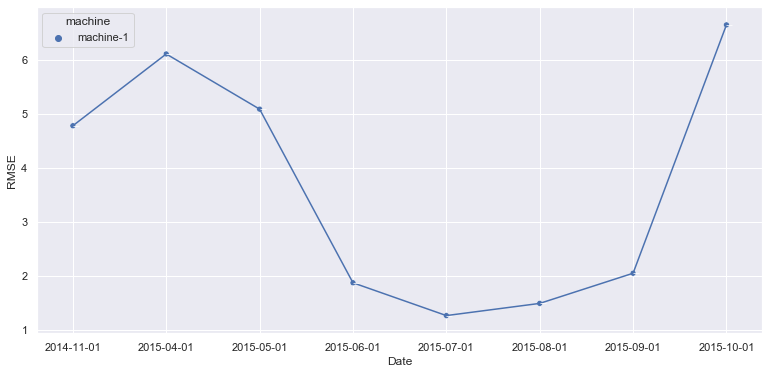

In [117]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

### Saving prediction for stacking

In [121]:
my_test_results['machine result'][0].to_csv('preds_stacking/preds_adaboost.csv',header = True, index = False)